# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Friday, 9/22/23, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

In [2]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Introduction

In this lab, you will use Monte Carlo analysis to estimate the expected
winnings for a couple of different games of chance.

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [3]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 5
 4
 6
 2
 4
 3
 4
 1
 2
 3
 3
 6
 ⋮
 3
 3
 6
 1
 3
 1
 1
 5
 4
 3
 1
 2

And then we can plot a histogram of these rolls:


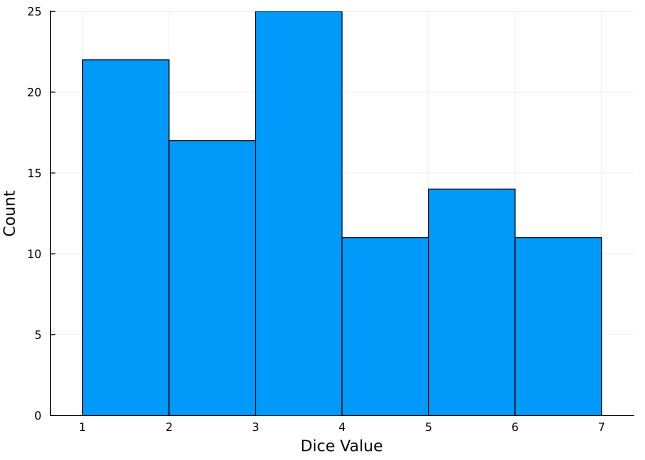

In [4]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercises (10 points)

In Problem 1, you will compute the probability of getting a specific
combination of multiple dice rolls. The focus will be on understanding
how the Monte Carlo estimate changes based on the number of simulations.

In Problem 2, we will implement the culmination of every episode of the
long-running game show [The Price Is
Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).
You will be asked to make a plot of expected winnings by bid for a
particular distribution of prize values.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

``` julia
Random.seed!(1)
```

    TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Problem 1 (5 points)

We want to know the probability of getting at least an 11 from rolling
three fair, six-sided dice (this is actually an old Italian game called
*passadieci*, which was analyzed by Galileo as one of the first examples
of a rigorous study of probability).

#### Problem 1.1 (1 point)

Write a function called `passadieci()` to simulate this game, which will
take as an input the number of realizations and output a vector of the
sum of the three dice rolls for each realization.

### Problem 1.2 (2 points)

Generate 5,000 simulations of the game using your `passadieci()`
function. Plot how the computed probability of winning the game changes
as the number of simulations increases (you can do this by computing the
frequency of wins for each additional simulation).

### Problem 1.3 (2 point)

Based on your plot from Problem 1.2, how many simulations were needed
for the win probability estimate to converge? What did you notice from
your plot about the estimates prior to convergence?

## Problem 2 (5 points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. We’ll assume that the
distribution of all showcases offered by the show is given as truncated
normal distribution, which means a normal distribution which has an
upper and/or lower bound. `Distributions.jl` makes it easy to specify
truncations on any distribution, not just normal distributions. For
example, we’ll use this distribution for the showcase values:

``` julia
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
```

    Truncated(Normal{Float64}(μ=31000.0, σ=4500.0); lower=5000.0, upper=42000.0)

#### Problem 2.1 (3 points)

Write a function `showcase()` which takes in a bid value and uses Monte
Carlo simulation to compute the expected value of the winnings. Make the
following assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

How did you decide how many samples to use within the function?

#### Problem 2.2 (2 points)

Plot the expected winnings for bids ranging from \$0 to \$42,000. What
do you notice?

## References

Put any consulted sources here, including classmates you worked with/who
helped you.